In [ ]:
%matplotlib inline 

# Predict where Patients in Post-Operative areas should be sent next

In this assignment, I select a data set from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.html), ingest the data from the website, perform some initial analyses to get a sense for what's in the data, then structure the data to fit a Scikit-Learn model and evaluate the results.

## Post-Operative Patient Data Set

Downloaded from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.html) on September 9, 2016. The first thing is to fully describe your data in a README file. The dataset description is as follows:
- Data Set: Multivariate
- Tasks: Classification
- Instances: 90
- Attributes: 8


### Data Set Information

The attributes correspond roughly to body temperature measurements of patients and the problem is to predict where patients in a postoperative recovery area should be sent to next. The data set can be used for the tasks of classification.


### Attribute Information:

1. L_CORE (patient's internal temperature in C): 
high (> 37), mid (>= 36 and <= 37), low (< 36) 
2. L_SURF (patient's surface temperature in C): 
high (> 36.5), mid (>= 36.5 and <= 35), low (< 35) 
3. L_O2 (oxygen saturation in %): 
excellent (>= 98), good (>= 90 and < 98), 
fair (>= 80 and < 90), poor (< 80) 
4. L_BP (last measurement of blood pressure): 
high (> 130/90), mid (<= 130/90 and >= 90/70), low (< 90/70) 
5. SURF_STBL (stability of patient's surface temperature): 
stable, mod-stable, unstable 
6. CORE_STBL (stability of patient's core temperature) 
stable, mod-stable, unstable 
7. BP_STBL (stability of patient's blood pressure) 
stable, mod-stable, unstable 
8. COMFORT (patient's perceived comfort at discharge, measured as 
an integer between 0 and 20) 
9. decision ADM-DECS (discharge decision): 
   - I (patient sent to Intensive Care Unit), 
   - S (patient prepared to go home), 
   - A (patient sent to general hospital floor)

### Relevant Papers

A. Budihardjo, J. Grzymala-Busse, L. Woolery (1991). Program LERS_LB 2.5 as a tool for knowledge acquisition in nursing, Proceedings of the 4th Int. Conference on Industrial & Engineering Applications of AI & Expert Systems, pp. 735-740. 
[[Web Link]](http://rexa.info/paper/6f7e59628b8ae4b2ddea962a54d24498ca701b3d)

L. Woolery, J. Grzymala-Busse, S. Summers, A. Budihardjo (1991). The use of machine learning program LERS_LB 2.5 in knowledge acquisition for expert system development in nursing. Computers in Nursing 9, pp. 227-234.



## Data Exploration

In this section we will begin to explore the dataset to determine relevant information.

In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

In [2]:
URL = "http://archive.ics.uci.edu/ml/machine-learning-databases/postoperative-patient-data/post-operative.data"

def fetch_data(fname='post-operative.txt'):
    """
    Helper method to retreive the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'w') as f:
        f.write(response.content)
    
    return outpath

# Fetch the data if required
POST_OP_DATA = fetch_data()

In [3]:
FEATURES  = [
    "L_CORE",
    "L_SURF",
    "L_02",
    "L_BP",
    "SURF_STBL",
    "CORE_STBL",
    "BP_STBL",
    "COMFORT",
    "decision"
]

Fnames = FEATURES[:-1]
decision = FEATURES[-1]


# Read the data into a DataFrame
df = pd.read_csv(POST_OP_DATA, sep=',', header=None, names=FEATURES)

print df.head(8)

  L_CORE L_SURF       L_02  L_BP SURF_STBL CORE_STBL     BP_STBL COMFORT  \
0    mid    low  excellent   mid    stable    stable      stable      15   
1    mid   high  excellent  high    stable    stable      stable      10   
2   high    low  excellent  high    stable    stable  mod-stable      10   
3    mid    low       good  high    stable  unstable  mod-stable      15   
4    mid    mid  excellent  high    stable    stable      stable      10   
5   high    low       good   mid    stable    stable    unstable      15   
6    mid    low  excellent  high    stable    stable  mod-stable      05   
7   high    mid  excellent   mid  unstable  unstable      stable      10   

  decision  
0        A  
1        S  
2        A  
3       A   
4        A  
5        S  
6        S  
7        S  


In [4]:
print df.describe()

       L_CORE L_SURF  L_02 L_BP SURF_STBL CORE_STBL BP_STBL COMFORT decision
count      90     90    90   90        90        90      90      90       90
unique      3      3     2    3         2         3       3       5        4
top       mid    mid  good  mid    stable    stable  stable      10        A
freq       58     48    47   57        45        83      46      65       63


In [5]:
# Determine the shape of the data
print "{} instances with {} features\n".format(*df.shape)

# Determine the frequency of each class
print df.groupby('decision')['decision'].count()

90 instances with 9 features

decision
A     63
A      1
I      2
S     24
Name: decision, dtype: int64


In [6]:
# It is reading the decision in row 4 as a different A, so I am going to drop that row.
df = df.drop([3])

In [7]:
# Describe the dataset

print df.describe()

       L_CORE L_SURF  L_02 L_BP SURF_STBL CORE_STBL BP_STBL COMFORT decision
count      89     89    89   89        89        89      89      89       89
unique      3      3     2    3         2         3       3       5        3
top       mid    mid  good  mid  unstable    stable  stable      10        A
freq       57     48    46   57        45        83      46      65       63


In [8]:
# Determine the shape of the data
print "{} instances with {} features\n".format(*df.shape)

# Determine the frequency of each class
print df.groupby('decision')['decision'].count()

89 instances with 9 features

decision
A    63
I     2
S    24
Name: decision, dtype: int64


In [9]:
data = df
data['L_CORE'] = data['L_CORE'].map({'low': 1,'mid': 2,'high':3})
data['L_SURF'] = data['L_SURF'].map({'low': 1,'mid': 2,'high':3})
data['L_BP'] = data['L_BP'].map({'low': 1,'mid': 2,'high':3})
data['L_02'] = data['L_02'].map({'poor': 1, 'fair': 2, 'good': 3,'excellent': 4})
data['SURF_STBL'] = data['SURF_STBL'].map({'unstable': 1,'mod-stable': 2,'stable':3})
data['CORE_STBL'] = data['CORE_STBL'].map({'unstable': 1,'mod-stable': 2,'stable':3})
data['BP_STBL'] = data['BP_STBL'].map({'unstable': 1,'mod-stable': 2,'stable':3})
data['COMFORT'] = data['COMFORT'].map({'15': 15,'10': 10,'?':10, '05' : 15, '07': 10})
data.head(10)

,L_CORE,L_SURF,L_02,L_BP,SURF_STBL,CORE_STBL,BP_STBL,COMFORT,decision
0,2,1,4,2,3,3,3,15,A
1,2,3,4,3,3,3,3,10,S
2,3,1,4,3,3,3,2,10,A
4,2,2,4,3,3,3,3,10,A
5,3,1,3,2,3,3,1,15,S
6,2,1,4,3,3,3,2,15,S
7,3,2,4,2,1,1,3,10,S
8,2,3,3,2,3,3,3,10,S
9,2,1,4,2,1,3,2,10,S
10,2,2,3,2,3,3,3,15,A


In [10]:
data['COMFORT'].dtype

dtype('int64')

By glancing at the first 5 rows of the data, we can see that we have primarily categorical data. Our target, `data.decision` is also currently constructed as a categorical field. Unfortunately, with categorical fields, we don't have a lot of visualization options (quite yet). However, it would be interesting to see the frequencies of each class, relative to the target of our classifier. To do this, we can use Seaborn's `countplot` function to count the occurrences of each data point.

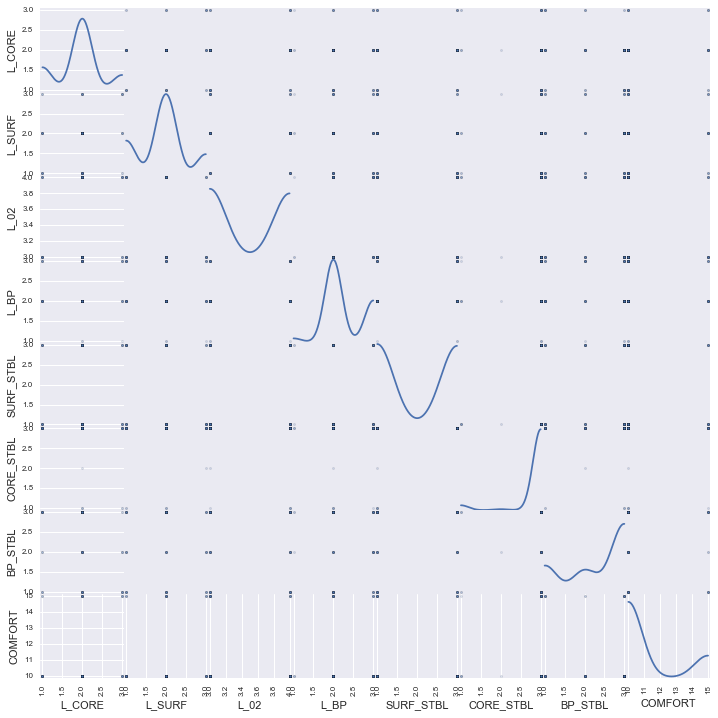

In [11]:
# Create a scatter matrix of the dataframe features
from pandas.tools.plotting import scatter_matrix
scatter_matrix(data, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

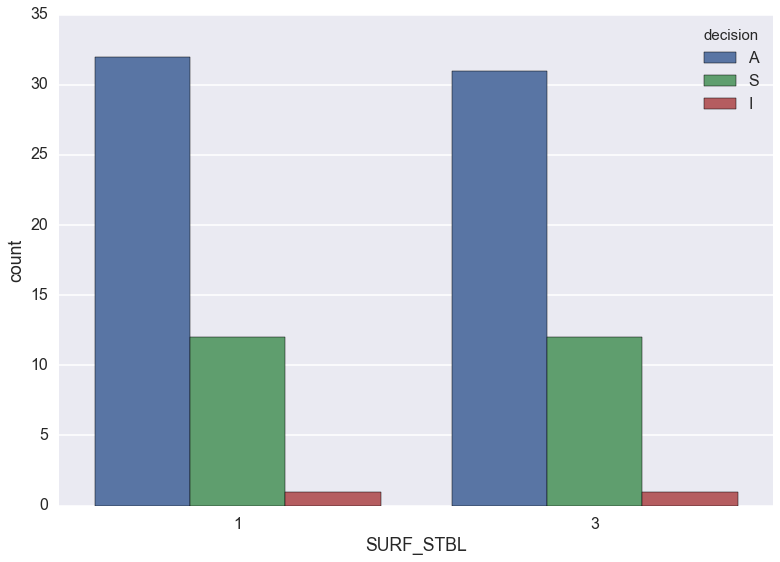

In [12]:
sns.set_context("poster")
sns.countplot(x='SURF_STBL', hue='decision', data = data,)

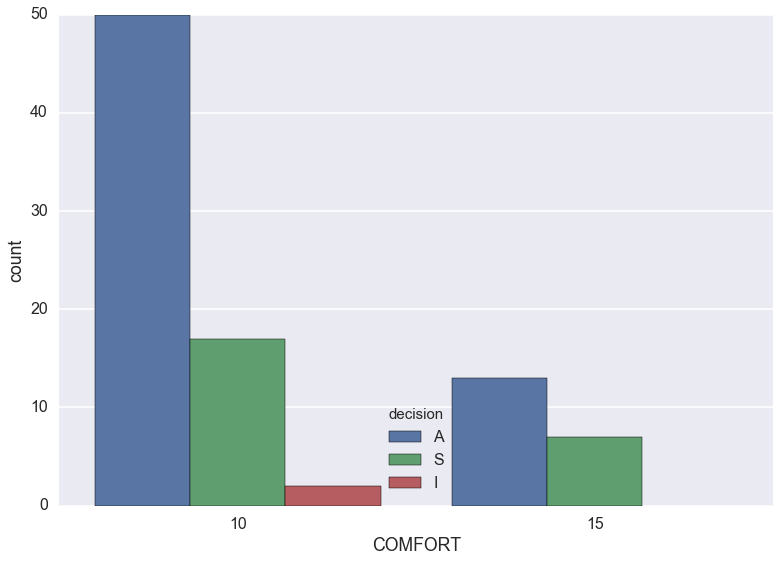

In [13]:
sns.set_context("poster")
sns.countplot(x='COMFORT', hue='decision', data = data,)

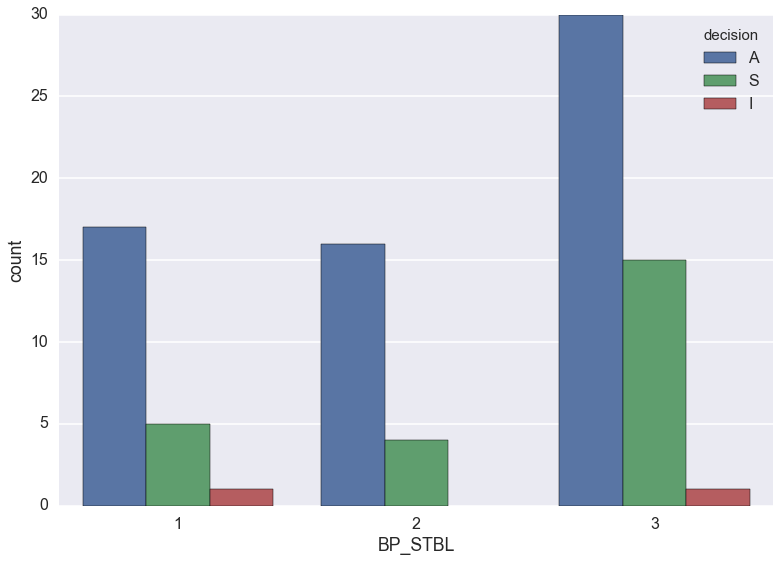

In [14]:
sns.set_context("poster")
sns.countplot(x='BP_STBL', hue='decision', data = data,)

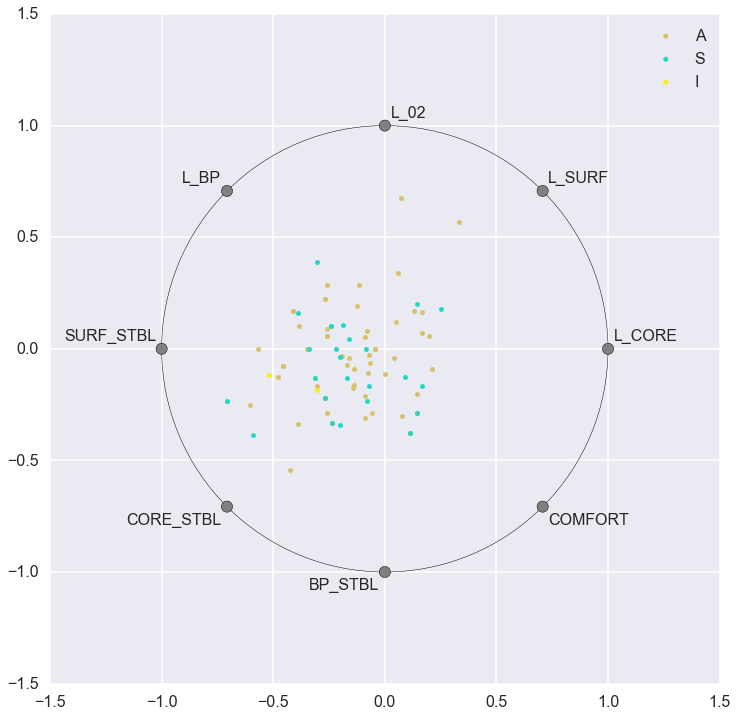

In [15]:
from pandas.tools.plotting import radviz
plt.figure(figsize=(12,12))
radviz(data, 'decision')
plt.show()

In [16]:
data = df
data.head(3)

,L_CORE,L_SURF,L_02,L_BP,SURF_STBL,CORE_STBL,BP_STBL,COMFORT,decision
0,2,1,4,2,3,3,3,15,A
1,2,3,4,3,3,3,3,10,S
2,3,1,4,3,3,3,2,10,A



## Data Management 

Now that we've completed some initial investigation and have started to identify the possible feautures available in our dataset, we need to structure our data on disk in a way that we can load into Scikit-Learn in a repeatable fashion for continued analysis. My proposal is to use the `sklearn.datasets.base.Bunch` object to load the data into `data` and `target` attributes respectively, similar to how Scikit-Learn's toy datasets are structured. Using this object to manage our data will mirror the native API and allow us to easily copy and paste code that demonstrates classifiers and technqiues with the built in datasets. Importantly, this API will also allow us to communicate to other developers and our future-selves exactly how to use the data. 

In order to organize our data on disk, we'll need to add the following files:

- `README.md`: a markdown file containing information about the dataset and attribution. Will be exposed by the `DESCR` attribute.
- `meta.json`: a helper file that contains machine readable information about the dataset like `target_names` and `feature_names`.

I constructed a pretty simple `README.md` in Markdown that gave the title of the dataset, the link to the UCI Machine Learning Repository page that contained the dataset, as well as a citation to the author. I simply wrote this file directly using my own text editor. 

The `meta.json` file, however, we can write using the data frame that we already have. We've already done the manual work of writing the column names into a `names` variable earlier, there's no point in letting that go to waste! 

In [19]:
import json 


meta = {
    'target_names': list(data.decision.unique()),
    'feature_names': list(data.columns),
    'categorical_features': {
        column: list(data[column].unique())
        for column in data.columns
        if data[column].dtype == 'object'
    },
}

with open('data/meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

In [20]:
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

This code creates a `meta.json` file by inspecting the data frame that we have constructued. The `target_names` column, is just the two unique values in the `data.income` series; by using the `pd.Series.unique` method - we're guarenteed to spot data errors if there are more or less than two values. The `feature_names` is simply the names of all the columns. 

Then we get tricky &mdash; we want to store the possible values of each categorical field for lookup later, but how do we know which columns are categorical and which are not? Luckily, Pandas has already done an analysis for us, and has stored the column data type, `data[column].dtype`, as either `int64` or `object`. Here I am using a dictionary comprehension to create a dictionary whose keys are the categorical columns, determined by checking the object type and comparing with `object`, and whose values are a list of unique values for that field. 

Now that we have everything we need stored on disk, we can create a `load_data` function, which will allow us to load the training and test datasets appropriately from disk and store them in a `Bunch`: 

In [21]:
from sklearn.datasets.base import Bunch

def load_data(root='data'):
    # Load the meta data from the file 
    with open(os.path.join(root, 'meta.json'), 'r') as f:
        meta = json.load(f) 
    
    names = meta['feature_names']
    
    # Load the readme information 
    with open(os.path.join(root, 'README.md'), 'r') as f:
        readme = f.read() 
    
    
    
    X = data[[
    "L_CORE",
    "L_SURF",
    "L_02",
    "L_BP",
    "SURF_STBL",
    "CORE_STBL",
    "BP_STBL",
    "COMFORT",
             ]]
    
    # Remove the target from the categorical features 
    meta['categorical_features'].pop('decision')
    
    y = data["decision"]
    
#    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size = 0.2,random_state=14)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size = 0.8,random_state=14)

    
    # Return the bunch with the appropriate data chunked apart
    return Bunch(
        #data = train[names[:-1]],
        data = X_train,
        #target = train[names[-1]], 
        target = y_train, 
        #data_test = test[names[:-1]], 
        data_test = X_test, 
        #target_test = test[names[-1]], 
        target_test = y_test, 
        target_names = meta['target_names'],
        feature_names = meta['feature_names'], 
        categorical_features = meta['categorical_features'], 
        DESCR = readme,
    )

dataset = load_data()

The primary work of the `load_data` function is to locate the appropriate files on disk, given a root directory that's passed in as an argument (if you saved your data in a different directory, you can modify the root to have it look in the right place). The meta data is included with the bunch, and is also used split the train and test datasets into `data` and `target` variables appropriately, such that we can pass them correctly to the Scikit-Learn `fit` and `predict` estimator methods. 

## Feature Extraction 

Now that our data management workflow is structured a bit more like Scikit-Learn, we can start to use our data to fit models. Unfortunately, the categorical values themselves are not useful for machine learning; we need a single instance table that contains _numeric values_. In order to extract this from the dataset, we'll have to use Scikit-Learn transformers to transform our input dataset into something that can be fit to a model. In particular, we'll have to do the following:

- encode the categorical labels as numeric data 
- impute missing values with data (or remove)

We will explore how to apply these transformations to our dataset, then we will create a feature extraction pipeline that we can use to build a model from the raw input data. This pipeline will apply both the imputer and the label encoders directly in front of our classifier, so that we can ensure that features are extracted appropriately in both the training and test datasets.  

### Label Encoding 

Our first step is to get our data out of the object data type land and into a numeric type, since nearly all operations we'd like to apply to our data are going to rely on numeric types. Luckily, Sckit-Learn does provide a transformer for converting categorical labels into numeric integers: [`sklearn.preprocessing.LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Unfortunately it can only transform a single vector at a time, so we'll have to adapt it in order to apply it to multiple columns. 

Like all Scikit-Learn transformers, the `LabelEncoder` has `fit` and `transform` methods (as well as a special all-in-one, `fit_transform` method) that can be used for stateful transformation of a dataset. In the case of the `LabelEncoder`, the `fit` method discovers all unique elements in the given vector, orders them lexicographically, and assigns them an integer value. These values are actually the indices of the elements inside the `LabelEncoder.classes_` attribute, which can also be used to do a reverse lookup of the class name from the integer value. 


Obviously this is very useful for a single column, and in fact the `LabelEncoder` really was intended to encode the target variable, not necessarily categorical data expected by the classifiers.

In order to create a multicolumn LabelEncoder, we'll have to extend the `TransformerMixin` in Scikit-Learn to create a transformer class of our own, then provide `fit` and `transform` methods that wrap individual `LabelEncoders` for our columns. My code, inspired by the StackOverflow post &ldquo;[Label encoding across multiple columns in scikit-learn](http://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn)&rdquo;, is as follows:

In [22]:
from sklearn.preprocessing import LabelEncoder 

from sklearn.base import BaseEstimator, TransformerMixin

class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None. 
    """
    
    def __init__(self, columns=None):
        self.columns  = columns 
        self.encoders = None
    
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode. 
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns 
        
        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns 
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame. 
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])
        
        return output

encoder = EncodeCategorical(dataset.categorical_features.keys())
data = encoder.fit_transform(dataset.data)

This specialized transformer now has the ability to label encode multiple columns in a data frame, saving information about the state of the encoders. It would be trivial to add an `inverse_transform` method that accepts numeric data and converts it to labels, using the `inverse_transform` method of each individual `LabelEncoder` on a per-column basis. 

### Imputation 

According to the `adult.names` file, unknown values are given via the `"?"` string. We'll have to either ignore rows that contain a `"?"` or impute their value to the row. Scikit-Learn provides a transformer for dealing with missing values at either the column level or at the row level in the `sklearn.preprocessing` library called the [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html).

The `Imputer` requires information about what missing values are, either an integer or the string, `Nan` for `np.nan` data types, it then requires a strategy for dealing with it. For example, the `Imputer` can fill in the missing values with the mean, median, or most frequent values for each column. If provided an axis argument of 0 then columns that contain only missing data are discarded; if provided an axis argument of 1, then rows which contain only missing values raise an exception. Basic usage of the `Imputer` is as follows:

```python
imputer = Imputer(missing_values='Nan', strategy='most_frequent')
imputer.fit(dataset.data)
```

Unfortunately, this would not work for our label encoded data, because 0 is an acceptable label &mdash; unless we could guarentee that 0 was always `"?"`, then this would break our numeric columns that already had zeros in them. This is certainly a challenging problem, and unfortunately the best we can do, is to once again create a custom Imputer. 

In [23]:
from sklearn.preprocessing import Imputer 

class ImputeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None. 
    """
    
    def __init__(self, columns=None):
        self.columns = columns 
        self.imputer = None
    
    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to impute. 
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns 
        
        # Fit an imputer for each column in the data frame
        self.imputer = Imputer(missing_values=0, strategy='most_frequent')
        self.imputer.fit(data[self.columns])

        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame. 
        """
        output = data.copy()
        output[self.columns] = self.imputer.transform(output[self.columns])
        
        return output

    
imputer = ImputeCategorical(['L_CORE', 'L_SURF', 'L_02', 'L_BP', 'SURF_STBL', 'CORE_STBL', 'BP_STBL'])
data = imputer.fit_transform(data)
data.head(90)

,L_CORE,L_SURF,L_02,L_BP,SURF_STBL,CORE_STBL,BP_STBL,COMFORT
5,2.0,2.0,3.0,2.0,1.0,3.0,1.0,15
84,2.0,1.0,3.0,2.0,3.0,3.0,1.0,10
86,2.0,1.0,3.0,2.0,3.0,3.0,1.0,10
0,2.0,3.0,3.0,2.0,1.0,3.0,2.0,10
94,3.0,1.0,3.0,2.0,3.0,3.0,1.0,15
103,1.0,2.0,4.0,3.0,1.0,3.0,1.0,10
77,1.0,2.0,3.0,3.0,1.0,3.0,3.0,10
4,3.0,2.0,3.0,3.0,3.0,3.0,1.0,15
32,1.0,2.0,4.0,3.0,3.0,3.0,2.0,10
87,3.0,2.0,4.0,2.0,1.0,1.0,3.0,10


Our custom imputer, like the `EncodeCategorical` transformer takes a set of columns to perform imputation on. In this case we only wrap a single `Imputer` as the `Imputer` is multicolumn &mdash; all that's required is to ensure that the correct columns are transformed.

I had chosen to do the label encoding first, assuming that because the `Imputer` required numeric values, I'd be able to do the parsing in advance. However, after requiring a custom imputer, I'd say that it's probably best to deal with the missing values early, when they're still a specific value, rather than take a chance. 

## Model Build 

Now that we've finally acheived our feature extraction, we can continue on to the model build phase. To create our classifier, we're going to create a [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that uses our feature transformers and ends in an estimator that can do classification. We can then write the entire pipeline object to disk with the `pickle`, allowing us to load it up and use it to make predictions in the future. 

A pipeline is a step-by-step set of transformers that takes input data and transforms it, until finally passing it to an estimator at the end. Pipelines can be constructed using a named declarative syntax so that they're easy to modify and develop. Our pipeline is as follows:

### Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# we need to encode our target data as well. 
yencode = LabelEncoder().fit(dataset.target)

# construct the pipeline 
rf = Pipeline([
        ('encoder',  EncodeCategorical(dataset.categorical_features.keys())),
        ('imputer', ImputeCategorical([
    "L_CORE",
    "L_SURF",
    "L_02",
    "L_BP",
    "SURF_STBL",
    "CORE_STBL",
    "BP_STBL",
    "COMFORT",
        ])), 
        ('classifier', RandomForestClassifier(n_estimators=20, oob_score=True, max_depth=7))
    ])


# ...and then run the 'fit' method to build a forest of trees
rf.fit(dataset.data, yencode.transform(dataset.target))


y_true = yencode.transform(dataset.target_test)

predicted  = rf.predict(dataset.data_test)


# Evaluate fit of the model
print "Mean Squared Error: %0.3f" % mse(y_true, predicted)
print "Coefficient of Determination: %0.3f" % r2_score(y_true, predicted)

Mean Squared Error: 0.966
Coefficient of Determination: -0.508


In [25]:
from sklearn.metrics import classification_report 
y_true = yencode.transform(dataset.target_test)

predicted  = rf.predict(dataset.data_test)

classificationReport = classification_report(y_true, predicted, target_names=["A", "S", "I"])

#classificationReport = classification_report(y_true, predicted)
print classificationReport

             precision    recall  f1-score   support

          A       0.75      0.75      0.75        52
          S       0.66      1.00      0.79        19
          I       0.25      0.11      0.15        18

avg / total       0.63      0.67      0.64        89



### C-Support Vector Classifier

In [26]:
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# we need to encode our target data as well. 
yencode = LabelEncoder().fit(dataset.target)

# construct the pipeline 
clf = Pipeline([
        ('encoder',  EncodeCategorical(dataset.categorical_features.keys())),
        ('imputer', ImputeCategorical([
    "L_CORE",
    "L_SURF",
    "L_02",
    "L_BP",
    "SURF_STBL",
    "CORE_STBL",
    "BP_STBL",
    "COMFORT",
        ])), 
        ('classifier', SVC(max_iter = 12))
    ])


# ...and then run the 'fit' method to build a forest of trees
clf.fit(dataset.data, yencode.transform(dataset.target))


y_true = yencode.transform(dataset.target_test)

predicted  = clf.predict(dataset.data_test)


# Evaluate fit of the model
print "Mean Squared Error: %0.3f" % mse(y_true, predicted)
print "Coefficient of Determination: %0.3f" % r2_score(y_true, predicted)

Mean Squared Error: 0.910
Coefficient of Determination: -0.421


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=12).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [28]:
from sklearn.metrics import classification_report 
y_true = yencode.transform(dataset.target_test)

predicted  = clf.predict(dataset.data_test)

classificationReport = classification_report(y_true, predicted, target_names=["A", "S", "I"])

#classificationReport = classification_report(y_true, predicted)
print classificationReport

             precision    recall  f1-score   support

          A       0.75      0.85      0.79        52
          S       0.79      1.00      0.88        19
          I       0.33      0.11      0.17        18

avg / total       0.67      0.73      0.69        89



The last step is to save our model to disk for reuse later, with the `pickle` module:

In [30]:
import pickle 

def dump_model(model, path='data', name='classifier.pickle'):
    with open(os.path.join(path, name), 'wb') as f:
        pickle.dump(model, f)
        
dump_model(decision)

You should also dump meta information about the date and time your model was built, who built the model, etc. But we'll skip that step here, since this post serves as a guide. 

## Model Operation 

Now it's time to explore how to use the model. To do this, we'll create a simple function that gathers input from the user on the command line, and returns a prediction with the classifier model. Moreover, this function will load the pickled model into memory to ensure the latest and greatest saved model is what's being used. 

In [ ]:
def load_model(path='data/classifier.pickle'):
    with open(path, 'rb') as f:
        return pickle.load(f) 


def predict(model, meta=meta):
    data = {} # Store the input from the user
    
    for column in meta['feature_names'][:-1]:
        # Get the valid responses
        valid = meta['categorical_features'].get(column)
    
        # Prompt the user for an answer until good 
        while True:
            val = " " + raw_input("enter {} >".format(column))
            if valid and val not in valid:
                print "Not valid, choose one of {}".format(valid)
            else:
                data[column] = val
                break
    
    # Create prediction and label 
    yhat = model.predict(pd.DataFrame([data]))
    return yencode.inverse_transform(yhat)
            
    
# Execute the interface 
model = load_model()
predict(model)

The hardest part about operationalizing the model is collecting user input. Obviously in a bigger application this could be handled with forms, automatic data gathering, and other advanced techniques. For now, hopefully this is enough to highlight how you might use the model in practice to make predictions on unknown data. 

## Conclusion 

This walkthrough was an end-to-end look at how I performed a classification analysis of a dataset that I downloaded from the Internet. I tried to stay true to my exact workflow so that you could get a sense for how I had to go about doing things with little to no advanced knowledge. As a result, there are definitely some things I might change if I was going to do this over. 

Because there were originally only two data points 'I' in the decision column, when I trained the model, sometimes it did not see any of those. So, when I ran the model on the test data, I kept getting errors because it kept seeing new points 'I.'